In [1]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image

In [2]:
# Unzip the data
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", "r") as z:
    z.extractall(".")

In [3]:
train_dir = 'train'
test_dir = 'test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [4]:
# Implement the Dataset class
class CatDogDataset(Dataset):
    def __init__(self, file_list, directory, mode='train', transform=None):
        self.file_list = file_list
        self.dir = directory
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
                
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img.numpy().astype('float32'), self.label
        else:
            return img.numpy().astype('float32'), self.file_list[idx]
        

In [5]:
# Prepare train dataset
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [file for file in train_files if 'cat' in file]
dog_files = [file for file in train_files if 'dog' in file]

cats = CatDogDataset(cat_files, train_dir, mode='train', transform=data_transform)
dogs = CatDogDataset(dog_files, train_dir, mode='train', transform=data_transform)

train_data = ConcatDataset([cats, dogs])

In [6]:
# Prepare the dataloader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)

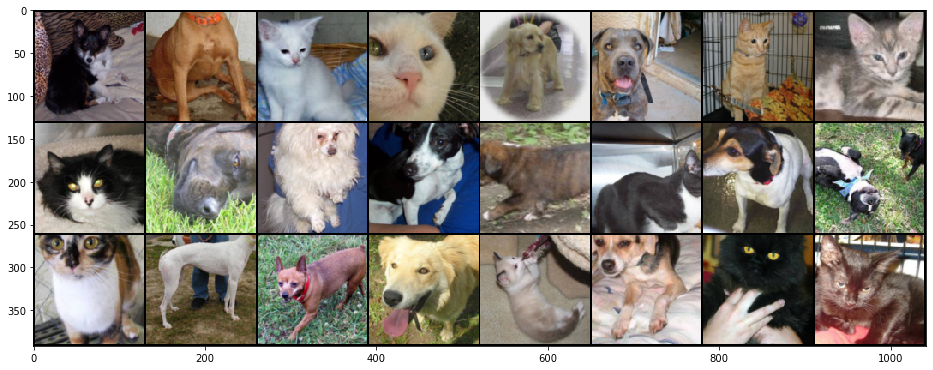

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Plot the images
fig = plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(images[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [10]:
images.shape, labels.shape # (batch_size, channels, hight, width), (batch_size, 1)

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [18]:
# Download a pre-trained model
device = 'cuda'
model = torchvision.models.resnet152(pretrained=True)

In [19]:
# Let's see how does the architecture look
model 
# Freeze the model parameters for transfer learning
# for param in model.parameters():
#     param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
import torch.nn as nn
from torch.optim import Adam
# Define and Update the last fully-connected layer
input_size = model.fc.in_features
output_size = 2
model.fc = nn.Sequential(
    nn.Linear(input_size, 1000),
    nn.Linear(1000, 500),
    nn.Linear(500, output_size))
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

[Epoch 1/2] Iteration 20 -> Train Loss: 1.1533, Accuracy: 0.469
[Epoch 1/2] Iteration 40 -> Train Loss: 0.7465, Accuracy: 0.516
[Epoch 1/2] Iteration 60 -> Train Loss: 0.6921, Accuracy: 0.562
[Epoch 1/2] Iteration 80 -> Train Loss: 0.6828, Accuracy: 0.578
[Epoch 1/2] Iteration 100 -> Train Loss: 0.6430, Accuracy: 0.578
[Epoch 1/2] Iteration 120 -> Train Loss: 0.5978, Accuracy: 0.641
[Epoch 1/2] Iteration 140 -> Train Loss: 0.5215, Accuracy: 0.719
[Epoch 1/2] Iteration 160 -> Train Loss: 0.5393, Accuracy: 0.781
[Epoch 1/2] Iteration 180 -> Train Loss: 0.4865, Accuracy: 0.688
[Epoch 1/2] Iteration 200 -> Train Loss: 0.4744, Accuracy: 0.797
[Epoch 1/2] Iteration 220 -> Train Loss: 0.4047, Accuracy: 0.859
[Epoch 1/2] Iteration 240 -> Train Loss: 0.3554, Accuracy: 0.844
[Epoch 1/2] Iteration 260 -> Train Loss: 0.3334, Accuracy: 0.859
[Epoch 1/2] Iteration 280 -> Train Loss: 0.3365, Accuracy: 0.797
[Epoch 1/2] Iteration 300 -> Train Loss: 0.2936, Accuracy: 0.812
[Epoch 1/2] Iteration 320 -> 

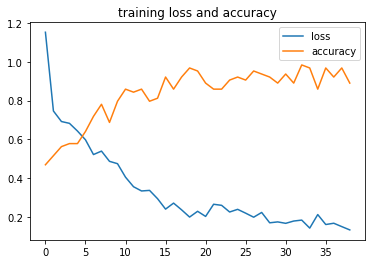

In [22]:
# Model training
num_epochs = 2
train_loss = 0
print_every = 20
counter = 1
loss_list = []
acc_list = []
model.train
for i in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if counter % print_every == 0:
            predicted_labels = torch.argmax(preds, dim=1)
            corrects = predicted_labels.eq(labels)
            accuracy = torch.mean(corrects.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'\
                  .format(i+1, num_epochs, counter, train_loss/print_every, accuracy))
            loss_list.append(train_loss/print_every)
            acc_list.append(accuracy)
            train_loss = 0
        counter += 1
        
# Plot the training history
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [23]:
model_path = 'ckpt_resnet152_catdog.pth'
torch.save(model.state_dict(), model_path)

In [24]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle=False, num_workers=4)

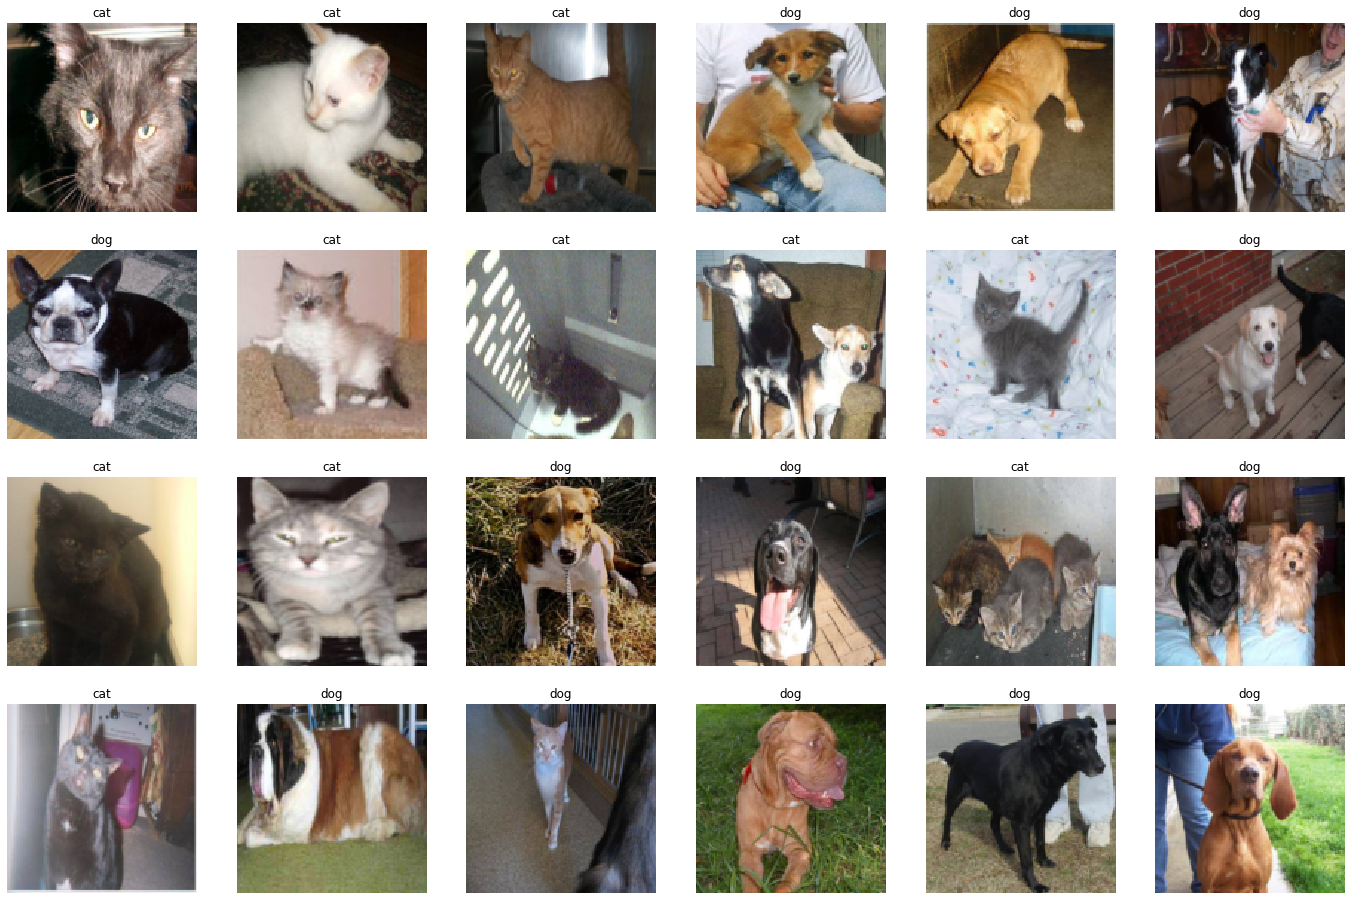

In [25]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))